In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import calibration_curve

In [2]:
# Load the breast cancer dataset as toy example
X, y = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Shape of data:', X.shape)
print('Shape of response:', y.shape)

Shape of data: (569, 30)
Shape of response: (569,)


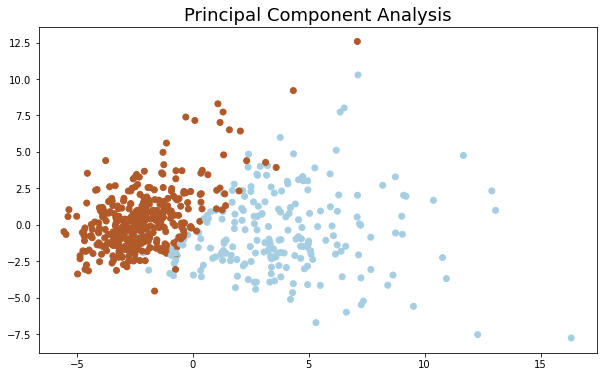

In [3]:
# Use standard scaler as PCA requires zero mean, unit variance inputs (whitening)
sc = StandardScaler()
X_normalized = sc.fit_transform(X)
# Apply PCA 
pca = PCA(n_components = 2).fit(X_normalized)
pca_X = pca.transform(X_normalized)

# Plot result
plt.figure(figsize=(10,6))
plt.title("Principal Component Analysis", fontsize=18)
plt.scatter(pca_X[:,0], pca_X[:,1], c=y, cmap='Paired')
plt.show()

In [4]:
# Set up pipeline components
scaler = StandardScaler()
pca = PCA()
logistic = LogisticRegression()

# Combine into pipeline
pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('logistic', logistic)])

# Set up a grid of hyperparameters
param_grid = {
    'pca__n_components': [1, 2, 5, 10, 15, 30],
    'logistic__penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'logistic__solver': ['newton-cg', 'lbfgs']
}

# Optimise in a 3-fold cross-validation
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=3)#, scoring='roc_auc')
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Get test set predictions
prob_pos = search.predict_proba(X_test)[:, 1]

Best parameter (CV score=0.969):
{'logistic__penalty': 'l2', 'logistic__solver': 'newton-cg', 'pca__n_components': 10}


In [5]:
# Print out cross validation results
search.cv_results_

{'mean_fit_time': array([0.01205357, 0.01344697, 0.01307019, 0.01724505, 0.02819864,
        0.03824194, 0.01266344, 0.00953658, 0.0084757 , 0.01499804,
        0.01792876, 0.01312669, 0.00234731, 0.00196703, 0.00164636,
        0.00153104, 0.00127721, 0.00145022, 0.00142066, 0.00172742,
        0.00150673, 0.00203093, 0.00159899, 0.00146612, 0.00532095,
        0.0077761 , 0.01056902, 0.01285267, 0.01399914, 0.0114572 ,
        0.00614238, 0.00779573, 0.00809932, 0.0111076 , 0.01181563,
        0.01132107, 0.00188128, 0.00175643, 0.00167155, 0.00189058,
        0.00179466, 0.00177566, 0.00189193, 0.00173736, 0.00184059,
        0.00154257, 0.00168459, 0.00144625]),
 'std_fit_time': array([1.05466115e-03, 2.31266576e-03, 1.31593384e-03, 3.03814864e-03,
        5.60049618e-03, 1.31405597e-02, 4.45495535e-03, 2.78839927e-03,
        7.17423897e-04, 3.50938863e-03, 6.72946716e-03, 1.00004751e-03,
        4.22375917e-04, 4.08586396e-04, 8.58592351e-05, 8.51716981e-05,
        5.84791738e-0

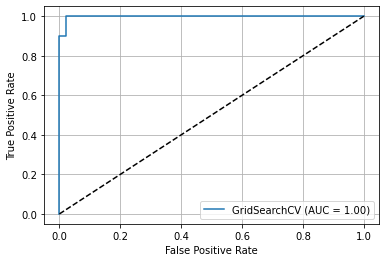

In [6]:
# Plot ROC Curve
from sklearn.metrics import plot_roc_curve
plot_roc_curve(search, X_test, y_test)
plt.plot((0, 1), (0, 1), linestyle='--', c='black')
plt.grid()
plt.show()

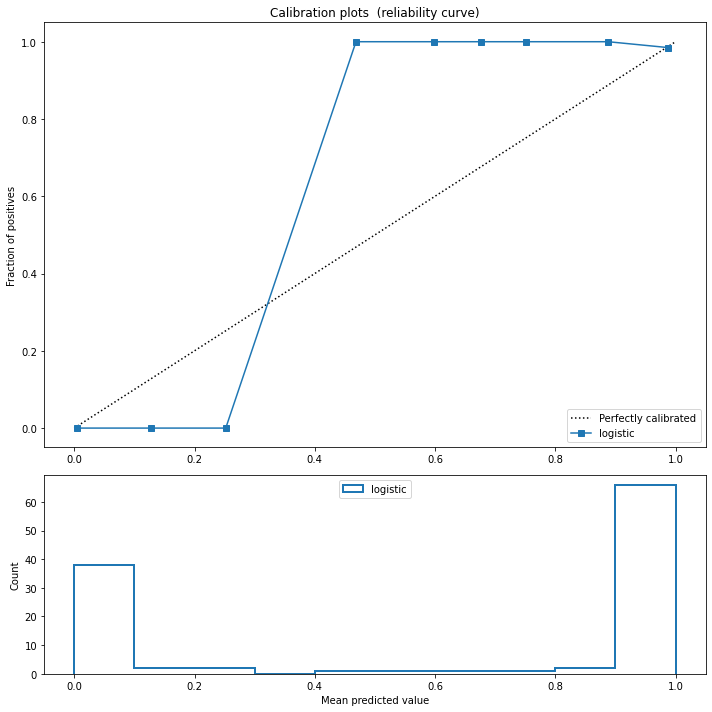

In [7]:
# Plot calibration
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
name = 'logistic'

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

fraction_of_positives, mean_predicted_value = \
    calibration_curve(y_test, prob_pos, n_bins=10)

ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
         label="%s" % (name, ))

ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
         histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()